# Called Third Strike
## Part 5. Improved neural network  

![](./resources/baseball_umpire_home_plate_1.jpg)

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to iterate on the work done with the [first attempts](03_first_crude_neural_network.ipynb) at at a neural network based approach. A few ideas:
- Included Handedness of both pitcher and batter; I hypothesize that this will have some signal with regards to the 'strike-ness' of the horizontal movement of the pitch. As for verticality, I think that the stringer data helps with that since it provides fairly concrete guardrails as to the strike-ness (assuming the umpire sees the same thing haha).
- Include pitch break and angle. I hypothesize this acts like a proxy to the pitcher, without having to rely on the pitcher_IDs. Rough analogy but I think of it kind of like latent factors in ALS matrix factorization (which I need to brush up on heh).

---
---

### Table of Contents<a id='toc'></a>

<a href='#data_prep'>1. Data Preprocessing</a>

<a href='#build_model'>2. Build Model</a>

<a href='#random_search'>3. Random Hyperparameter Search</a>

...

<a href='#the_end'>Go to the End</a>

---

---  

<span style="font-size:0.5em;">Tag 1</span>

### Data Preprocessing<a id='data_prep'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>


#### Libraries


In [2]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime
 
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, plot_roc_curve

# neural networks
# Kera Sequential model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

2022-05-06 04:22:41.091101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-06 04:22:41.091136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Import the following packages, if needed (not included in default packages on the platform I'm currently using)

In [3]:
%%capture
try:
    import scikeras
except ImportError:
    !pip install scikeras[tensorflow]
    !python -m pip install scikeras[tensorflow]
except ModuleNotFoundError:
    !pip install scikeras[tensorflow]
    # !python -m pip install scikeras[tensorflow]

In [4]:
from scikeras.wrappers import KerasClassifier

In [5]:
# Dependency for plot_model function

In [6]:
%%capture
try:
    import pydot
except ImportError:
    !pip install pydot

---

#### Data Import 

Retrieve the latest version of our train/test files that we built during [initial exploration](02_data_exploration.ipynb).

In [7]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_test = pd.read_pickle('../data/test_enriched.pkl')

Let's refamiliarize ourselves with the features.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353983 entries, 0 to 354038
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pitch_id              353983 non-null  object        
 1   inning                353983 non-null  int64         
 2   side                  353983 non-null  object        
 3   run_diff              353983 non-null  int64         
 4   at_bat_index          353983 non-null  int64         
 5   pitch_of_ab           353983 non-null  int64         
 6   batter                353983 non-null  int64         
 7   pitcher               353983 non-null  int64         
 8   catcher               353983 non-null  int64         
 9   umpire                353983 non-null  int64         
 10  bside                 353983 non-null  object        
 11  pside                 353983 non-null  object        
 12  stringer_zone_bottom  353983 non-null  float64       
 13 

---

#### Feature Selection and Prep, revisited

Select features:

For our initial super simple model, we had picked just four features: 
- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top

In [22]:
# Features selected
feat_select = ['px', 'pz', 'stringer_zone_bottom', 'stringer_zone_top']

But as mentioned in the intro, I want to try adding `bside` and `pside`, as well as vertical/horizontal breaks and angles (`break_x`, `break_z`, `angle_x`, `angle_z`), and `pitch_speed`. 

##### Adding `break_x`, `break_z`, `angle_x`, `angle_z`, `pitch_speed`

These are numeric so I will add on to `feat_select`

In [23]:
feat_select = feat_select + ['break_x', 'break_z', 'angle_x', 'angle_z', 'pitch_speed']
feat_select = list(set(feat_select)) #Just to ensure no dupes if this cell gets executed again
display(feat_select)

['break_z',
 'stringer_zone_top',
 'angle_z',
 'stringer_zone_bottom',
 'break_x',
 'pz',
 'px',
 'angle_x',
 'pitch_speed']

##### Adding `b_side`, `p_side`

These are strings so I will one-hot encode them.

In [25]:
feat_cat_select = ['bside', 'pside']

In [37]:
df_train_cat_ohe = pd.get_dummies(df_train[feat_cat_select])

In [29]:
df_train_cat_ohe.head(3)

,bside_L,bside_R,pside_L,pside_R
0,0,1,1,0
1,1,0,0,1
2,1,0,1,0


In [38]:
df_train_cat_ohe.shape

(353983, 4)

Prep features:

Gather up all the selected features.

In [63]:
# Get just the selected features
df_X = pd.concat([df_train[feat_select], df_train_cat_ohe], axis=1)
# df_X = df_train_cat_ohe.copy()
display(df_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353983 entries, 0 to 354038
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   break_z               353983 non-null  float64
 1   stringer_zone_top     353983 non-null  float64
 2   angle_z               353983 non-null  float64
 3   stringer_zone_bottom  353983 non-null  float64
 4   break_x               353983 non-null  float64
 5   pz                    353983 non-null  float64
 6   px                    353983 non-null  float64
 7   angle_x               353983 non-null  float64
 8   pitch_speed           353983 non-null  float64
 9   bside_L               353983 non-null  uint8  
 10  bside_R               353983 non-null  uint8  
 11  pside_L               353983 non-null  uint8  
 12  pside_R               353983 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 28.4 MB


None

In [64]:
df_X.head()

,break_z,stringer_zone_top,angle_z,stringer_zone_bottom,break_x,pz,px,angle_x,pitch_speed,bside_L,bside_R,pside_L,pside_R
0,-9.54142,3.41,5.59379,1.56,1.915350,2.302170,-1.298100,3.02727,97.4298,0,1,1,0
1,-21.94270,3.47,6.86676,1.59,-12.137300,1.574430,1.412220,-1.56782,91.7712,1,0,0,1
2,-25.51070,3.58,7.17281,1.68,-0.992261,2.112480,-0.181190,2.04966,87.8130,1,0,1,0
3,-27.25090,3.55,8.50392,1.63,-2.839300,0.598692,-0.885538,2.96845,86.5546,0,1,1,0
4,-14.31720,3.55,5.63426,1.63,-6.419950,2.018200,0.900718,-2.64734,95.0891,0,1,0,1


While we are at it, let's prep our targets:

In [65]:
df_y = df_train['strike_bool']
display(pd.DataFrame(df_y).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353983 entries, 0 to 354038
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   strike_bool  353983 non-null  int64
dtypes: int64(1)
memory usage: 5.4 MB


None

---

#### Feature Engineering

Select features:

For a neural network we will need to numerically represent our data (e.g. one-hot-encode any categorical features), as well as scale/normalize the data. 

All the selected features for this round are numerical, so we don't have to worry about encoding any categories. For scaling I'm choosing to *standardize*.

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

---

#### Train / Test


Create train/test splits.

Breakout parameters for easy access.

In [67]:
# Parameters
test_size = 0.20
random_state = 24

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_y, test_size=test_size
                                                    ,stratify=df_y, random_state = random_state)

---  

<span style="font-size:0.5em;">Tag 2</span>

### Build Model<a id='build_model'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

---

#### First Neural Network Model

Let's set up our initial parameters and build our models.

We will use the Kera Sequential model.

In [69]:
# Initial Parameters
num_inputs = X_train.shape[1]
num_units_dense_1 = 2
num_outputs = 1
activ_dense = 'sigmoid'
activ_output = 'sigmoid'

n_epochs = 2
val_split = 0.10

Model: "seq_model_strike"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 2)                 28        
                                                                 
 Output (Dense)              (None, 1)                 3         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


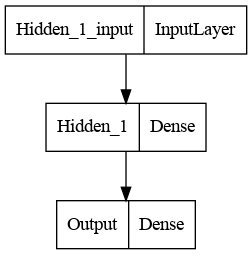

In [70]:
# Create a Sequential model
model = Sequential(name='seq_model_strike')

# Add an input layer and a hidden layer with 10 neurons
model.add(Dense(num_units_dense_1, input_shape=(num_inputs,)
                ,activation=activ_dense, name='Hidden_1'))

# Add a 1-neuron output layer
model.add(Dense(num_outputs, activation=activ_output, name='Output'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam'
              ,metrics=['accuracy']
             )

# Summarise your model
model.summary()

plot_model(model)

In [71]:
f"To keep it realtively simple, we chose to use {num_units_dense_1} nodes in 1 hidden layer."

'To keep it realtively simple, we chose to use 2 nodes in 1 hidden layer.'

---

#### Model training

We will save the model `History`.

In [72]:
# Train model
mod_hist =  model.fit(X_train, y_train, epochs = n_epochs
                        ,validation_split=val_split)

Epoch 1/2
7965/7965 [==============================] - 8s 939us/step - loss: 0.6073 - accuracy: 0.6820 - val_loss: 0.5530 - val_accuracy: 0.6834
Epoch 2/2
7965/7965 [==============================] - 8s 959us/step - loss: 0.4714 - accuracy: 0.7550 - val_loss: 0.4405 - val_accuracy: 0.7772


Not too bad through 2 epochs. Kind of weird that train accuracy is lower than validation accuracy, but we won't worry too much about it right now; only if we keep seeing it consistently in subsequent runs/tuning.

Let's convert the history to a `DataFrame` for easier manipulation.

In [73]:
df_mod_history = (pd.DataFrame(mod_hist.history).reset_index()
                  .rename(columns={'index': 'epoch', 'loss': 'train_loss'
                                   ,'accuracy': 'train_accuracy'}) 
                 )

In [74]:
df_mod_history

,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,0,0.607338,0.681960,0.553030,0.683428
1,1,0.471365,0.755029,0.440463,0.777181


Let's do a quick viz on the accuracy over the two epochs.

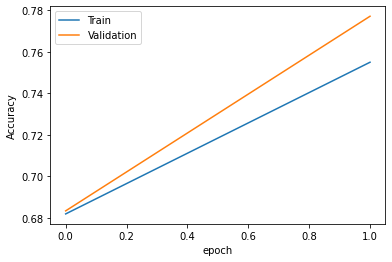

In [75]:
_ = sns.lineplot(data=df_mod_history, x='epoch', y='train_accuracy')
_ = sns.lineplot(data=df_mod_history, x='epoch', y='val_accuracy')
# _.set(ylim=(min_y,1))
_.set_ylabel("Accuracy")
plt.legend(labels=["Train","Validation"])
plt.show()

Let's evaluate the model on the *test* set.

In [76]:
# Evaluate model accuracy on the test set
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

2213/2213 [==============================] - 2s 688us/step - loss: 0.4376 - accuracy: 0.7804
Accuracy: 0.7804426550865173


Test accuracy of .74 is in line with what we saw out of train/val (.72/0.75).

Now that we created a single model as a warmup, let's try to hone in on a good candidate using Random Hyperparameter Search.

---  

<span style="font-size:0.5em;">Tag 3</span>

### Random Hyperparameter Search<a id='random_search'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

#### Preparation

Let's create functions for:
- Model build

In reviewing methodology to use `keras` with `sklearn`, I found `scikeras`. Their [tutorial](https://www.adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#4.2-Saving-using-Keras-saving-methods) has a lot of good examples on how to leverage `sklearn` functionality but use Keras models, so alot of the following will be leveraging those example codes.

Create model build function to create a binary classification neural network model that ingests the current set of parameters.

In [77]:
# Full credit to scikeras tutorial (see 2.2 in 'tutorial' link above)
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    return model

Instantiate a `scikeras` classifier:

In [78]:
clf = KerasClassifier(
    model=get_clf,
    loss="binary_crossentropy",
    optimizer="adam",
    optimizer__lr=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5,
    verbose=True,
    metrics=['binary_accuracy'],
    validation_split=0.10
)

# clf.fit(X_train, y_train)

Let's create a grid of parameters and do a random search to identify the most promising combination.


Create `dict` of parameters to perform random search on.

In [79]:
params = {
    'optimizer__lr': [0.001, 0.01, 0.05, 0.5],
    'model__hidden_layer_sizes': [(100,), (50, 50, )],
    'model__dropout': [0, 0.5],
    'epochs': [2, 3, 5],
    'batch_size': [32, 128, 256]
}

Instantiate the `RandomSearchCV` object:

In [80]:
rs = RandomizedSearchCV(estimator=clf
                        ,param_distributions=params
                        ,cv=5
                        ,refit=True
                        ,verbose=True
                        )

Fit to the training data!

In [81]:
rs_results = rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/3
797/797 [==============================] - 2s 2ms/step - loss: 0.2393 - binary_accuracy: 0.8955 - val_loss: 0.1702 - val_binary_accuracy: 0.9296
Epoch 2/3
797/797 [==============================] - 2s 2ms/step - loss: 0.1973 - binary_accuracy: 0.9164 - val_loss: 0.1682 - val_binary_accuracy: 0.9303
Epoch 3/3
222/222 [==============================] - 0s 570us/step
Epoch 1/3
797/797 [==============================] - 2s 2ms/step - loss: 0.2414 - binary_accuracy: 0.8941 - val_loss: 0.1711 - val_binary_accuracy: 0.9273
Epoch 2/3
797/797 [==============================] - 2s 2ms/step - loss: 0.2001 - binary_accuracy: 0.9166 - val_loss: 0.1680 - val_binary_accuracy: 0.9296
Epoch 3/3
222/222 [==============================] - 0s 595us/step
Epoch 1/3
797/797 [==============================] - 2s 2ms/step - loss: 0.2332 - binary_accuracy: 0.8987 - val_loss: 0.1759 - val_binary_accuracy: 0.9263
Epoch 2/3
797/797 [===========

Let's look at the best accuracy score, and the parameters that produced them.

In [82]:
display(rs_results.best_score_, rs_results.best_params_)

0.9297069772108933

{'optimizer__lr': 0.01,
 'model__hidden_layer_sizes': (100,),
 'model__dropout': 0.5,
 'epochs': 3,
 'batch_size': 256}

Let's look at it as an estimator object.

In [83]:
rs_best = rs_results.best_estimator_
display(rs_best)

KerasClassifier(
	model=<function get_clf at 0x7f7ab8b61a60>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=['binary_accuracy']
	batch_size=256
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=3
	optimizer__lr=0.01
	model__hidden_layer_sizes=(100,)
	model__dropout=0.5
	class_weight=None
)

Let's look at a high level plot of the model, to make sure it makes sense vis a vis the best params.

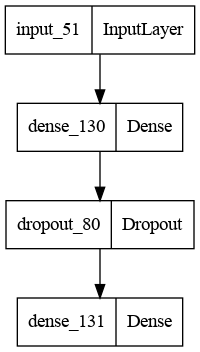

In [84]:
plot_model(rs_best.model_)

Look at summary:

In [85]:
rs_best.model_.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 100)               1400      
                                                                 
 dropout_80 (Dropout)        (None, 100)               0         
                                                                 
 dense_131 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


Now let's look at performance vs Test.

In [86]:
display(f"test accuracy: {rs_best.score(X_test, y_test)}")
display(f"train accuracy: {rs_results.best_score_}")

277/277 [==============================] - 0s 600us/step


'test accuracy: 0.9292201646962442'

'train accuracy: 0.9297069772108933'

Consistent, and aligns.

Let's get some predictions and review some high level classification metrics:

In [87]:
rs_pred = rs_best.predict(X_test)

277/277 [==============================] - 0s 579us/step


*Confusion Matrix*

In [88]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45974,  2669],
       [ 2342, 19812]])

*Accuracy*

In [89]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

277/277 [==============================] - 0s 597us/step


'test accuracy: 0.929'

*Precision*

In [90]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,3)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.881'

*Recall*

In [91]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 3)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.894'

*ROC/AUC*

1107/1107 [==============================] - 1s 597us/step


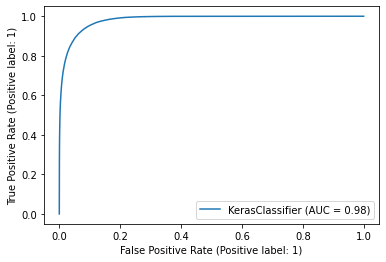

In [92]:
plot_roc_curve(rs_best, X_train, y_train)
plt.show()

AUC of 0.98!

*Save the current state*

Let's save out the best model!

In [93]:
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
model_nm = 'nn_2nd_pass_' + str_ts
model_path = './models/' + model_nm
pred_path = './predictions/test/' + model_nm + '.csv'

display(model_path, pred_path)

# save out predicted probabilities
pred_curr = rs_best.predict_proba(X_test)
np.savetxt(pred_path, pred_curr, delimiter=",")

# Save out Keras model
rs_best.model_.save(model_path)

'./models/nn_2nd_pass_20220506_0530'

'./predictions/test/nn_2nd_pass_20220506_0530.csv'

277/277 [==============================] - 0s 663us/step


2022-05-06 05:30:10.007640: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/nn_2nd_pass_20220506_0530/assets


---  

<span style="font-size:0.5em;">Tag 4</span>

<a id='the_end'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

-----

### Archive

Here is the model creation function I started building, before I stumbled across `scikeras` and decided to run with their code.

In [ ]:
%%script echo skipping
def create_binary_nn_model(num_inputs, learning_rate=0.01, num_layers=1
                           ,num_nodes=2, activation='relu'):
    """Create binary neural network Sequential model"""
    # Create Adam optimizer
    opt = Adam(lr=learning_rate)
    
    # Create Sequential model
    model=Sequential()
    
    # Input layer
    model.add(Dense(num_nodes, input_shape=(num_inputs,) 
              ,activation=activation, name='Input'))
    
    # Additional Hidden Layers
    for i in range(num_layers-1): #if only 1 then assume just input/hidden
        model.add(Dense(num_nodes, activation=activation))
    
    # Add a 1-neuron output layer
    model.add(Dense(num_outputs, activation='sigmoid', name='Output'))

    # Compile your model
    model.compile(loss='binary_crossentropy', optimizer=opt
                  ,metrics=['accuracy']
                 )

    return model

Let's do a test on the function:

In [ ]:
%%script echo skipping
mod_1 = create_binary_nn_model(num_inputs=X_train.shape[1]
                               ,learning_rate=1
                               ,num_layers=1
                              )

In [ ]:
%%script echo skipping
hh = mod_1.fit(X_train, y_train, epochs = n_epochs
                        ,validation_split=val_split)

In [ ]:
%%script echo skipping
plot_model(mod_1)

Seems correct. I think that I plugged in a learning rate of 1 caused the epochs to be basically the same, basically skipping over minimums.